<a href="https://colab.research.google.com/github/AkkXu/Booklytics-Dashboard/blob/main/eda_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Booklytic: Web Scraping & Dashboard Project on Bookstore Insights

## 1.Project Overview

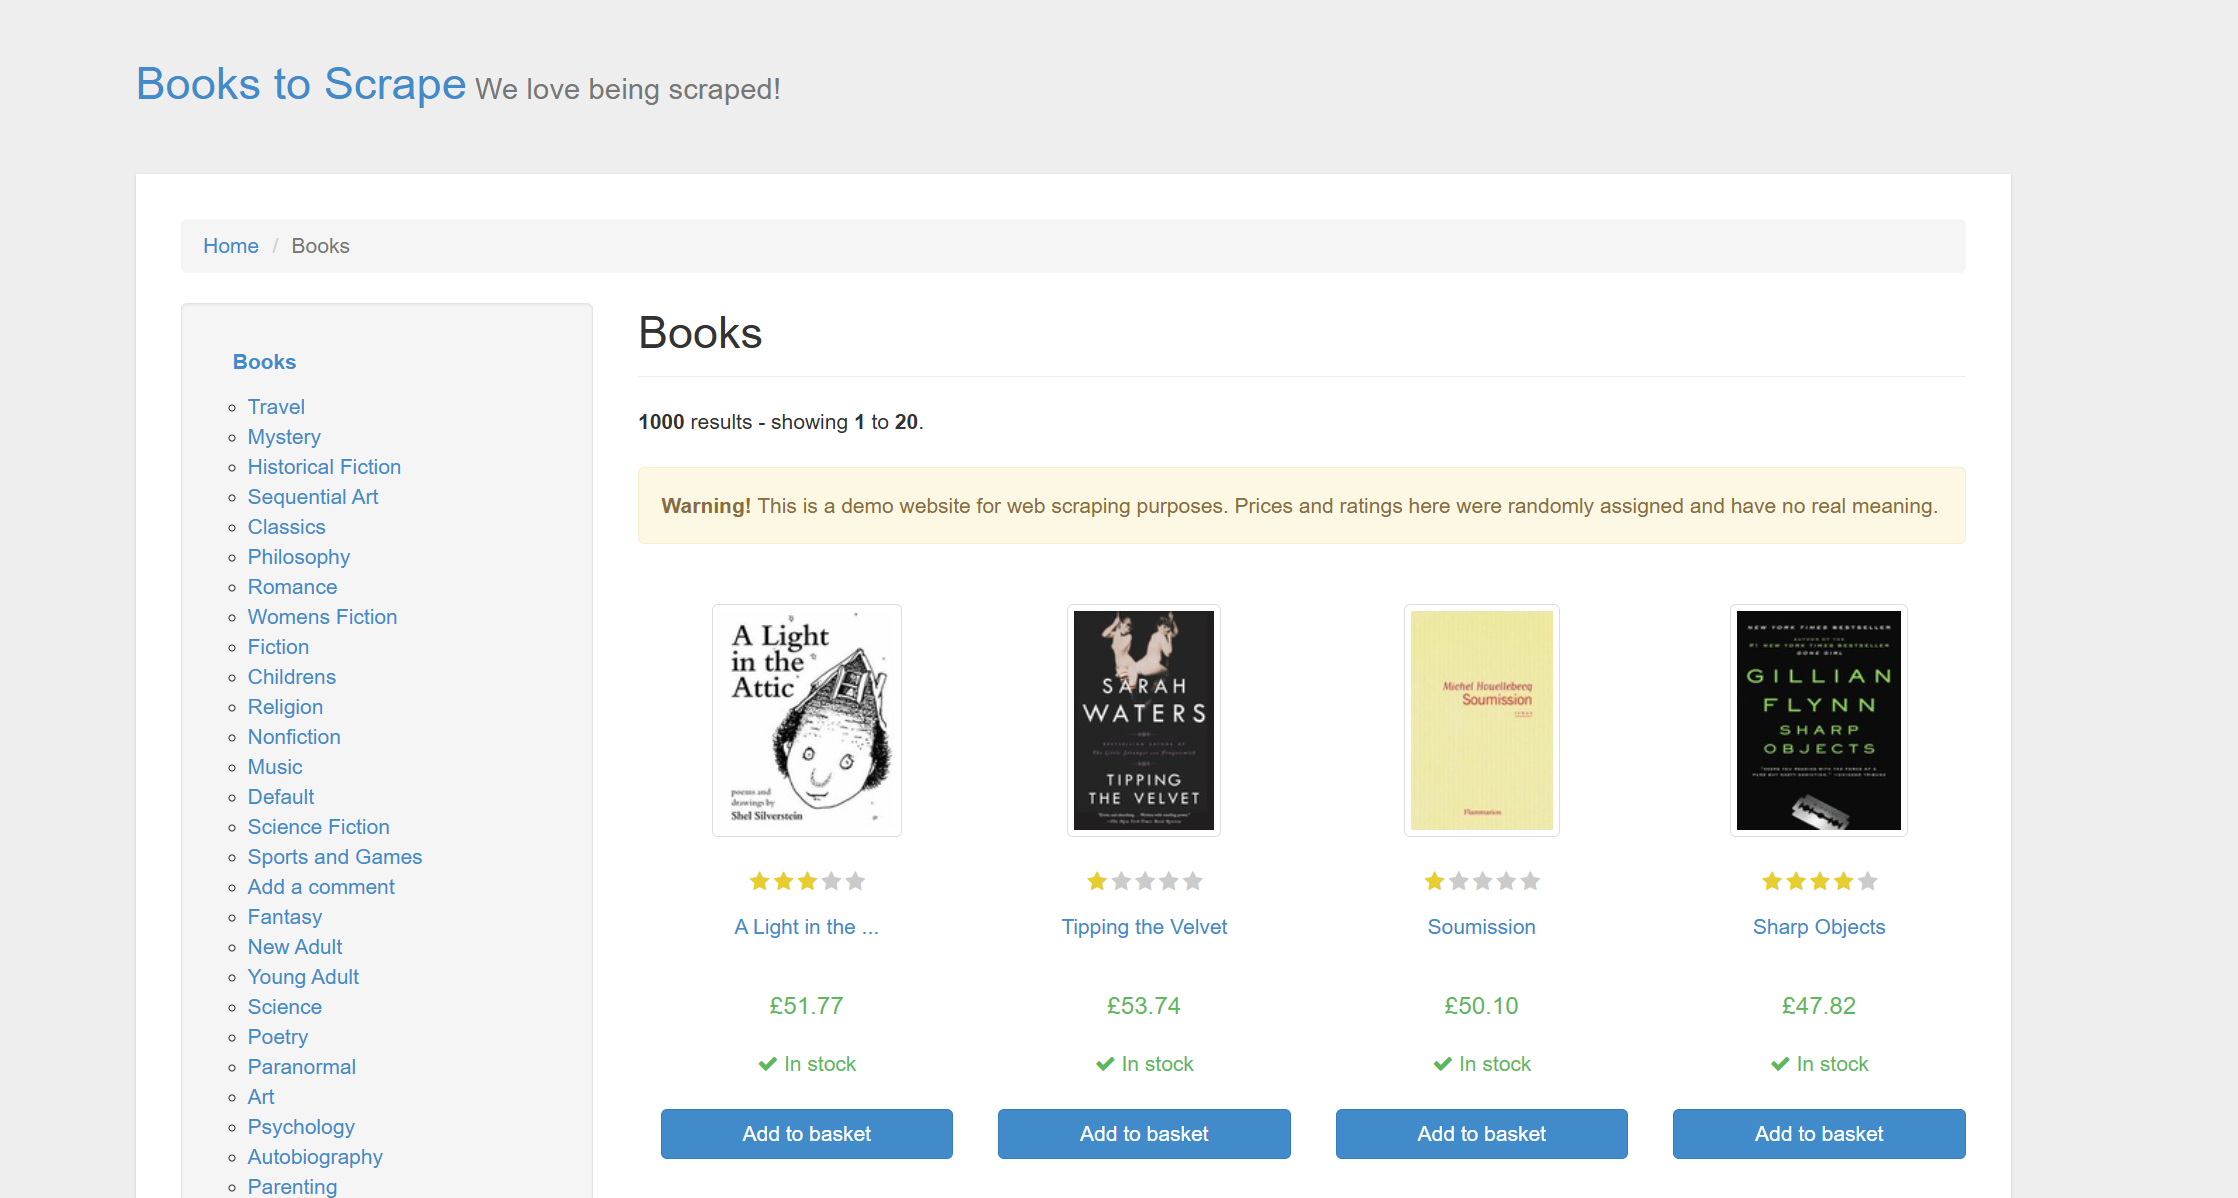

Booklytic is a data pipeline project focused on extracting and analyzing book data from Books to Scrape — a demo website created for practicing web scraping techniques.

The project involves scraping 1,000 book entries across 50 pages, capturing key attributes such as title, price, availability, and rating. After collection, the data is cleaned, structured, and analyzed to uncover patterns and insights.

The final outcome includes both exploratory data visualizations and an interactive dashboard, demonstrating practical skills in web scraping, data wrangling, EDA, and dashboard development.

## 2.Process Summary
Step 1 – Scraping:
We extract relevant information including book title, price, availability status, and rating using requests and BeautifulSoup.

Step 2 – Data Cleaning:
The scraped data is cleaned and structured using pandas, handling inconsistent formats, trimming whitespaces, and converting prices.

Step 3 – Data Visualization:
We use visualizations (e.g., bar charts, pie charts, word clouds) to explore patterns and trends in the dataset.

Step 4 – Dashboard:
The cleaned and visualized data can be used to build a Streamlit dashboard or similar app to showcase insights interactively.

** This project demonstrates skills in web scraping, data wrangling, visualization, and preparing data pipelines for dashboard deployment. **

## 3.import required packages

In [1]:
!pip install requests beautifulsoup4 pandas matplotlib seaborn

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 4.Data Collection



### 4.1 Data Scraping

Scraped book data from all 50 pages of Books to Scrape using requests and BeautifulSoup.
Extracted key fields: title, price, availability, and rating.
Stored results in a pandas DataFrame with 1,000 entries, saved as books_all_pages.csv.

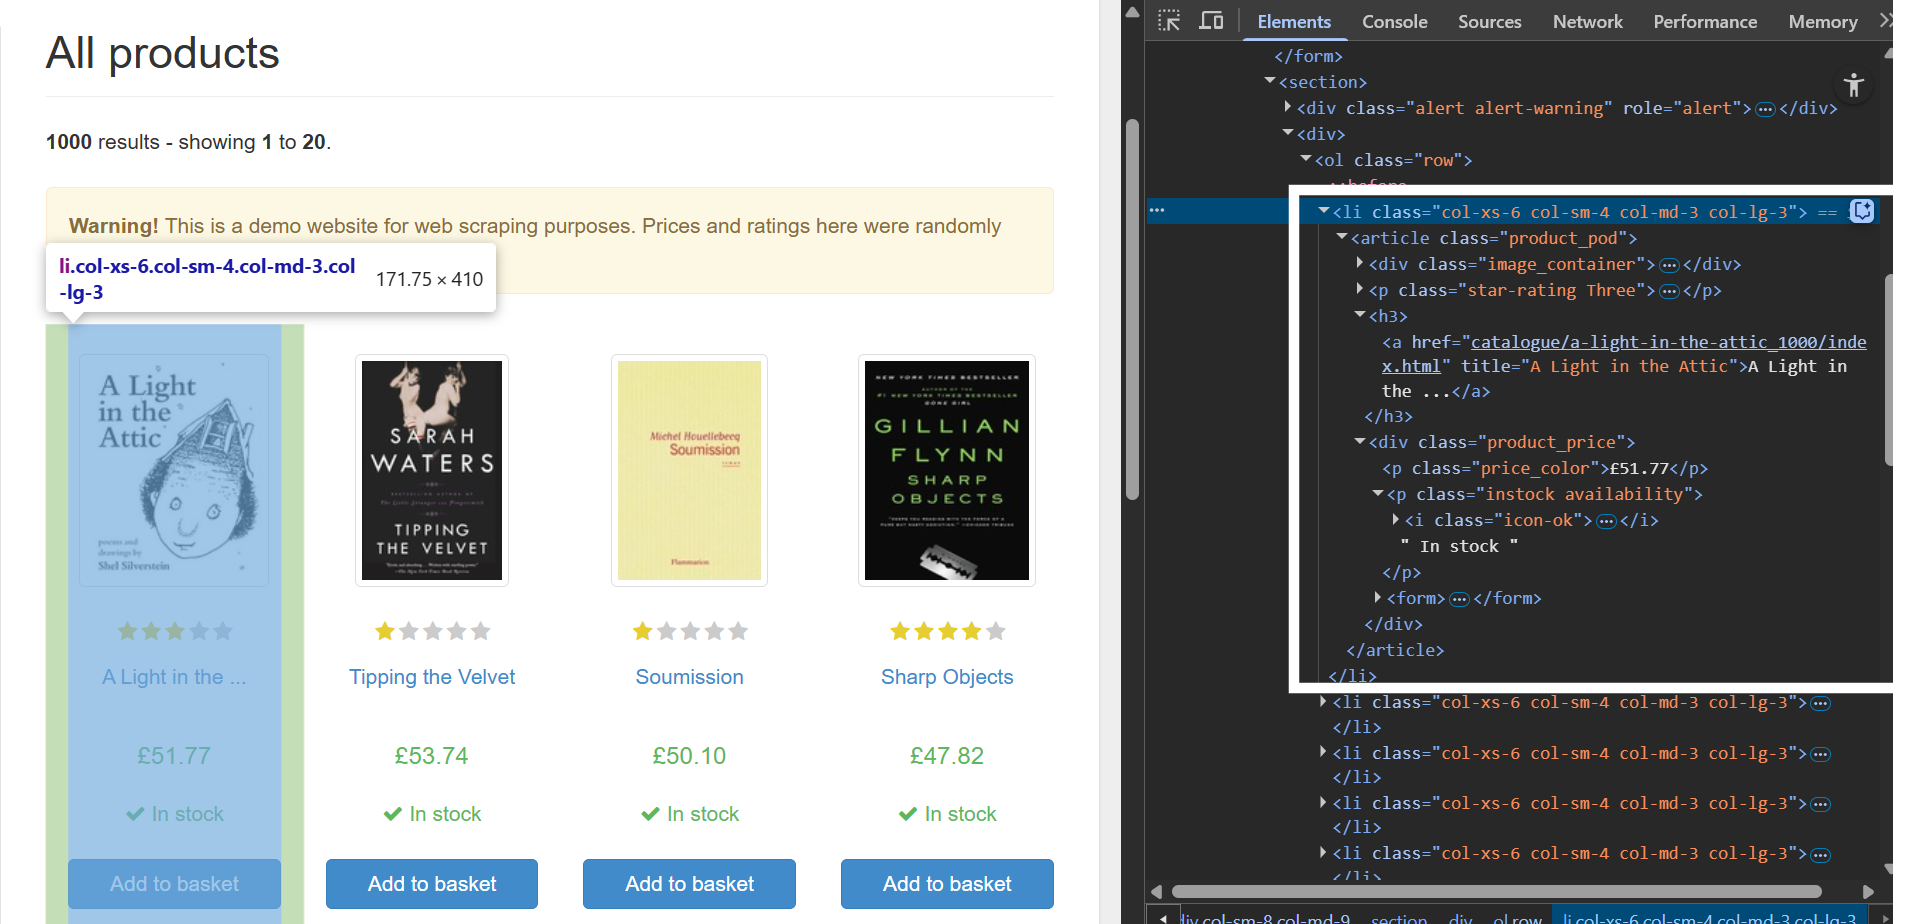

The structure of each book listing is wrapped in an `<article>` tag with the class `product_pod`, which contains nested elements for the title (`<a title=...>`), price (`<p class="price_color">`), availability (`<p class="instock availability">`), and rating (`<p class="star-rating">` via class attribute).


In [2]:
book_data = []

for page in range(1, 51):
    url = f"http://books.toscrape.com/catalogue/page-{page}.html"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    books = soup.find_all('article', class_='product_pod')

    for book in books:
        title = book.h3.a['title']
        price = book.find('p', class_='price_color').text
        availability = book.find('p', class_='instock availability').text.strip()
        rating = book.p['class'][1]

        book_data.append({
            'title': title,
            'price': price,
            'availability': availability,
            'rating': rating
        })

df = pd.DataFrame(book_data)
df.to_csv("books_all_pages.csv", index=False)
print(f"Scraped {len(df)} books and saved to books_all_pages.csv")

Scraped 1000 books and saved to books_all_pages.csv


In [3]:
df.sample(5)

,title,price,availability,rating
23,Chase Me (Paris Nights #2),Â£25.27,In stock,Five
840,Girl in the Blue Coat,Â£46.83,In stock,Two
419,10-Day Green Smoothie Cleanse: Lose Up to 15 P...,Â£49.71,In stock,Five
301,Hamilton: The Revolution,Â£58.79,In stock,Three
530,How to Be a Domestic Goddess: Baking and the A...,Â£28.25,In stock,Two


### 4.2 Data Wrangling

In this step, we clean and transform the scraped data to prepare it for analysis and visualization.

Data Cleaning & Transformation Steps:

1. **Check for missing values**  
   - Inspect the dataset using `df.isnull().sum()` to ensure no critical field is missing before processing.

2. **Clean `price` column**  
   - Remove unwanted characters (e.g., `Â`, `£`)  
   - Convert to numeric for aggregation and visualization

3. **Convert `rating` from string to integer**  
   - Map values such as `"Five"` → `5` for quantitative analysis

4. **Create new features for analysis**  
   - `title_length`: Length of the book title  
   - `availability_binary`: Convert availability to 1 (in stock) or 0 (out of stock)  
   - `is_series_book`: Flag whether the book appears to be part of a series  
   - `price_category`: Categorize price into bins (Low, Mid, High)

These transformations ensure that the dataset is clean, complete, and ready for deeper insights through EDA and dashboard visualization.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1000 non-null   object
 1   price         1000 non-null   object
 2   availability  1000 non-null   object
 3   rating        1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


Check for missing values

In [5]:
df.isnull().sum()

,0
title,0
price,0
availability,0
rating,0


Clean price column

In [6]:
df['price'] = df['price'].str.replace(r'[^\d\.]','',regex=True).astype(float)

In [7]:
rating_list = {'One': 1, 'Two':2, 'Three':3, 'Four':4, 'Five':5}
df['rating'] = df['rating'].str.strip().map(rating_list)

In [8]:
df.sample(5)

,title,price,availability,rating
392,"The Sleep Revolution: Transforming Your Life, ...",11.68,In stock,4
38,Behind Closed Doors,52.22,In stock,4
151,The Love and Lemons Cookbook: An Apple-to-Zucc...,37.60,In stock,2
17,Mesaerion: The Best Science Fiction Stories 18...,37.59,In stock,1
931,The Iliad,16.16,In stock,1


Add more related features

In [9]:
#Add title length
df['title_length'] = df['title'].str.len()
#Add availability_binary
df['availability_binary'] = df['availability'].apply(lambda x:1 if 'In stock' in x else 0  )


In [10]:
#check df['price']
df['price'].describe()

,price
count,1000.00000
mean,35.07035
std,14.44669
min,10.00000
25%,22.10750
50%,35.98000
75%,47.45750
max,59.99000


In [11]:
#Add price category
df['price_category'] = pd.cut(df['price'], bins=[0,20,40,60], labels=['low', 'midium', 'high'])

In [12]:
#Add series_book
def check_series(title):
    title = title.lower()
    keywords = ['vol.', 'vol ', '#', 'book', 'part', 'season', 'no.', 'episode', 'chapter']
    return int(any(k in title for k in keywords))

df['series_book'] = df['title'].apply(check_series)


In [13]:
df.sample(10)

,title,price,availability,rating,title_length,availability_binary,price_category,series_book
664,No One Here Gets Out Alive,20.02,In stock,5,26,1,midium,0
217,"Wonder Woman: Earth One, Volume One (Wonder Wo...",37.34,In stock,4,64,1,midium,1
592,The Mathews Men: Seven Brothers and the War Ag...,42.91,In stock,5,68,1,high,0
518,Raymie Nightingale,34.41,In stock,2,18,1,midium,0
77,"Saga, Volume 5 (Saga (Collected Editions) #5)",51.04,In stock,2,45,1,high,1
627,Find Her (Detective D.D. Warren #8),22.37,In stock,1,35,1,midium,1
629,Drama,38.70,In stock,2,5,1,midium,0
83,"Political Suicide: Missteps, Peccadilloes, Bad...",36.28,In stock,2,163,1,midium,0
743,The Infinities,27.41,In stock,1,14,1,midium,0
733,The Nightingale,26.26,In stock,4,15,1,midium,0


In [26]:
df.sort_values(by = 'price', ascending = False)

,title,price,availability,rating,title_length,availability_binary,price_category,series_book
648,The Perfect Play (Play by Play #1),59.99,In stock,3,34,1,high,1
617,Last One Home (New Beginnings #1),59.98,In stock,3,33,1,high,1
860,Civilization and Its Discontents,59.95,In stock,2,32,1,high,0
560,The Barefoot Contessa Cookbook,59.92,In stock,5,30,1,high,1
366,The Diary of a Young Girl,59.90,In stock,3,25,1,high,0
...,...,...,...,...,...,...,...,...
302,Greek Mythic History,10.23,In stock,5,20,1,low,0
84,Patience,10.16,In stock,3,8,1,low,0
716,The Tipping Point: How Little Things Can Make ...,10.02,In stock,2,62,1,low,0
501,The Origin of Species,10.01,In stock,4,21,1,low,0


In [14]:
df.to_csv("books_all_pages.csv", index=False)

In [15]:
from google.colab import files
files.download('books_all_pages.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5.Exploratory Data Analysis (EDA)

### 5.1 EDA Using Pandas and Matplotlib

In this section, we explore the dataset using both descriptive statistics and visualizations to bunderstand the hidden patterns and relationships between features. The analysis includes:

1.Single feature:

Distribution of numerical features such as `price`, `rating`, and `title_length`.

Frequency counts for categorical features such as `availability`, `price_category`, and `series_book`.


2.Double features:

Relationship between `rating` and `price`, to see if higher-rated books tend to be more expensive.

Comparison of `price` and `availability status`.

Influence of being part of a series_book on both `price` and `rating`.


**3. Feature Distribution Overview**  
- Use bar charts and boxplots to identify central tendency, spread, and outliers.  
- Compare key categorical groups against numerical targets.

**4. Correlation Matrix**  
- Heatmap of pairwise correlations among numeric variables (e.g., `price`, `rating`, `title_length`, `availability_binary`) to identify potential linear relationships.

#### 1.Singles feature Analysis

<Axes: xlabel='price', ylabel='Count'>

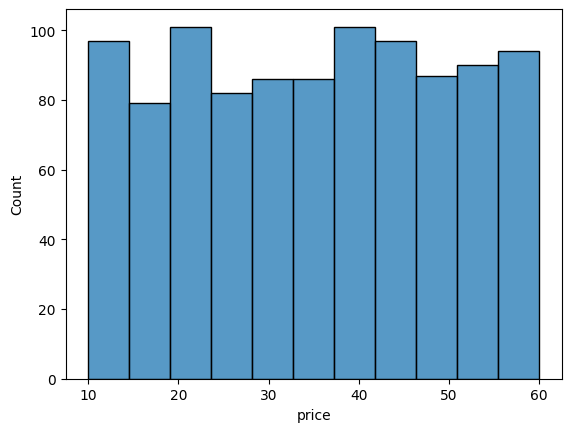

In [16]:
sns.histplot(df['price'])


<Axes: xlabel='rating', ylabel='count'>

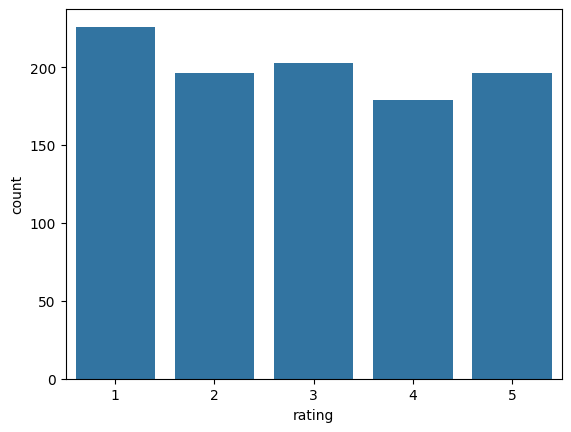

In [17]:
sns.countplot(x='rating', data=df)

<Axes: xlabel='availability', ylabel='count'>

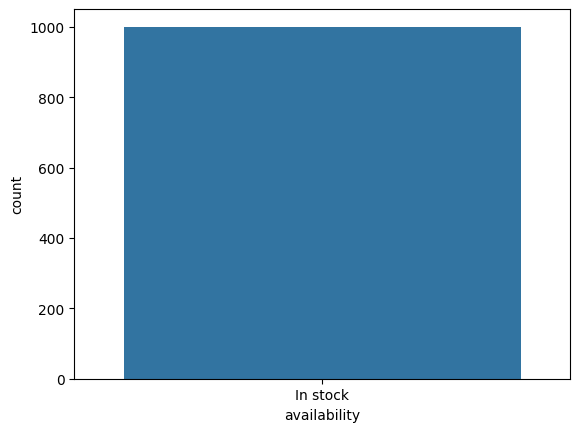

In [18]:
sns.countplot(x='availability', data=df)

#### 2.Double features Analysis

<ipython-input-19-555d12849bb6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='price', data=df, palette='Blues')
<ipython-input-19-555d12849bb6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='series_book', y='price', data=df, palette='Greens')
<ipython-input-19-555d12849bb6>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='series_book', y='rating', data=df, palette='Oranges')
<ipython-input-19-555d12849bb6>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. 

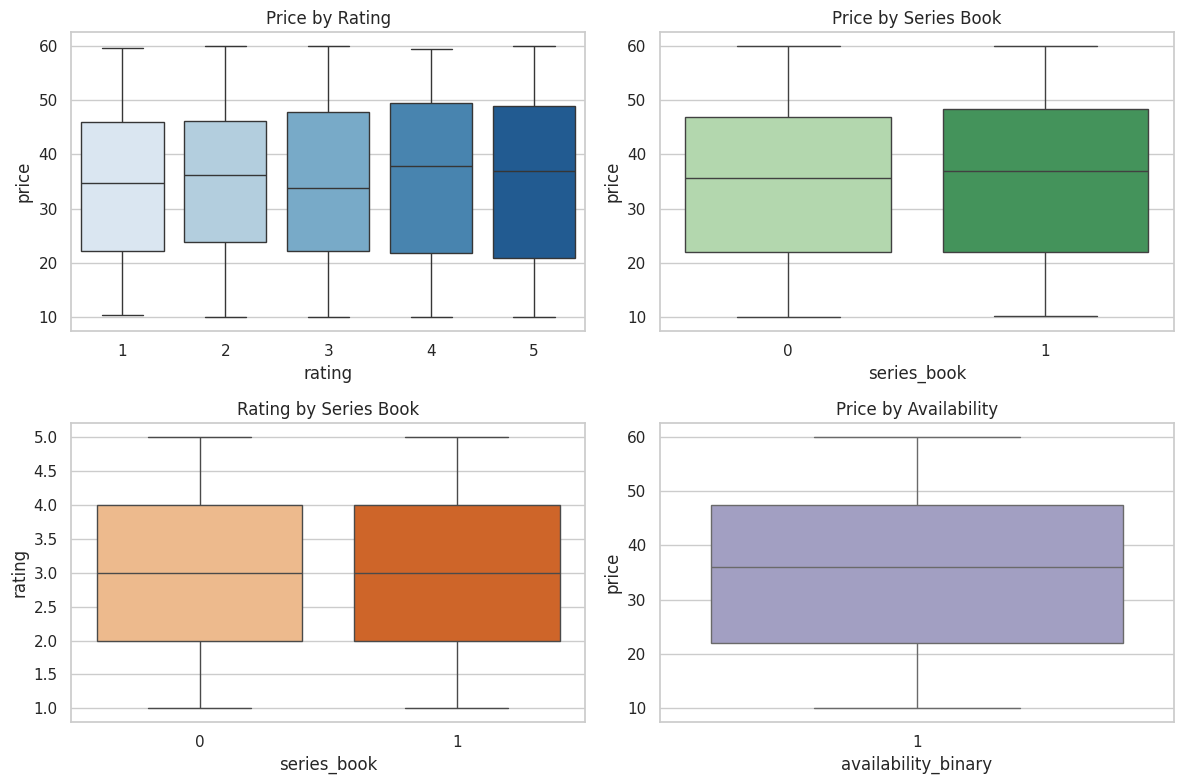

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

#Plot 1: Price vs Rating
plt.subplot(2, 2, 1)
sns.boxplot(x='rating', y='price', data=df, palette='Blues')
plt.title('Price by Rating')

#Plot 2: Price vs Series Book
plt.subplot(2, 2, 2)
sns.boxplot(x='series_book', y='price', data=df, palette='Greens')
plt.title('Price by Series Book')

#Plot 3: Rating vs Series Book
plt.subplot(2, 2, 3)
sns.boxplot(x='series_book', y='rating', data=df, palette='Oranges')
plt.title('Rating by Series Book')

#Plot 4: Price vs Availability
plt.subplot(2, 2, 4)
sns.boxplot(x='availability_binary', y='price', data=df, palette='Purples')
plt.title('Price by Availability')

plt.tight_layout()
plt.show()


#### 3.Correlation Analysis

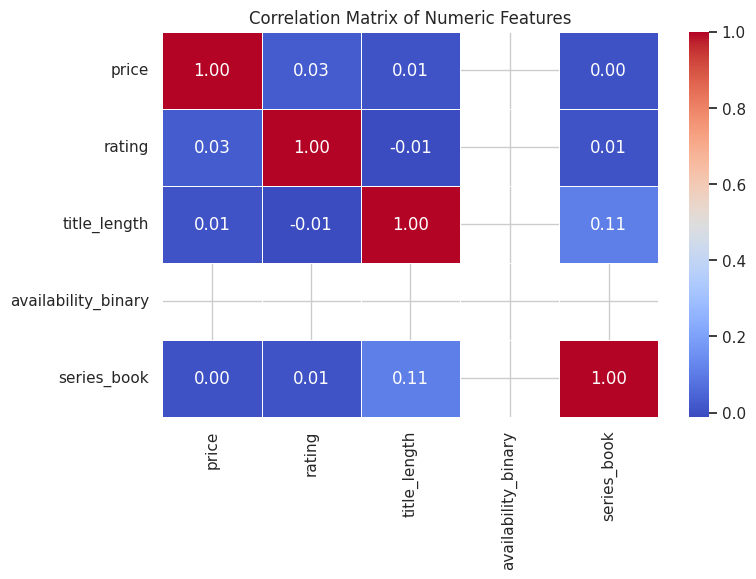

In [20]:

numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


#### 4.Conclusion

In this section, we conducted an exploratory data analysis to understand the distributions and relationships between features. Based on the visualizations and correlation matrix, the dataset appears to be uniformly distributed, which aligns with its purpose as a demo scraping dataset. Therefore, significant patterns or relationships are minimal, reinforcing the need to use more realistic data for further analysis in a production scenario.

## 6.Dashboard Development

This section focuses on building an interactive data visualization dashboard using the Dash framework. The dashboard presents insights from the scraped bookstore dataset through interactive charts and user controls like dropdowns and sliders. Users can explore the relationships between price, rating, availability, and series information through dynamic visualizations built with Plotly.

Below is the full source code for the dashboard implementation, written in Python using Dash and Plotly Express:

```
import pandas as pd
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

# Load data
df = pd.read_csv("books_all_pages.csv")
# Setup price for Range slider
min_price = df['price'].min()
max_price = df['price'].max()


# App setup
app = dash.Dash(__name__)
app.title = "Booklytics Dashboard"

# Layout
app.layout = html.Div([
    html.H1("Booklytics Dashboard", style={'textAlign': 'center'}),

    html.Label("Select a Graph:", style={'fontSize': 18}),
    # Dropdown
    dcc.Dropdown(
        id='graph-type',
        options=[
            {'label': 'Price by Rating', 'value': 'price-rating'},
            {'label': 'Price by Series Book', 'value': 'price-series'},
            {'label': 'Rating by Series Book', 'value': 'rating-series'},
            {'label': 'Price by Availability', 'value': 'price-availability'},
        ],
        value='price-rating',
        clearable=False,
        style={'width': '60%'}
    ),

    html.Br(),

    dcc.Graph(id='main-graph'),

    html.Hr(),

    html.H3("Price vs Rating", style={'textAlign': 'center'}),

    html.P("Filter by Price Range:"),
    #Range Slider
    dcc.RangeSlider(
        id='price-slider',
        min=min_price,
        max=max_price,
        value=[min_price, max_price],
        step=1,
        tooltip={"placement": "bottom"},
        marks={
            int(min_price): f"${int(min_price)}",
            int((min_price + max_price) / 2): f"${int((min_price + max_price) / 2)}",
            int(max_price): f"${int(max_price)}"
        }
    ),
    html.Br(),

    dcc.Graph(id='scatter-graph')
])

# Callback for dropdown
@app.callback(
    Output('main-graph', 'figure'),
    Input('graph-type', 'value')
)
def update_main_graph(graph_type):
    color_palette = px.colors.qualitative.Set2
    if graph_type == 'price-rating':
        fig = px.box(df, x='rating', y='price', color='rating', title='Price by Rating',
                     color_discrete_sequence=color_palette)
    elif graph_type == 'price-series':
        fig = px.box(df, x='series_book', y='price', color='series_book', title='Price by Series Book',
                     color_discrete_sequence=color_palette)
    elif graph_type == 'rating-series':
        fig = px.box(df, x='series_book', y='rating', color='series_book', title='Rating by Series Book',
                     color_discrete_sequence=color_palette)
    elif graph_type == 'price-availability':
        fig = px.box(df, x='availability', y='price', color='availability',
                     title='Price by Availability',
                     color_discrete_sequence=color_palette)
    else:
        fig = {}
    return fig

# Callback for scatter
@app.callback(
    Output('scatter-graph', 'figure'),
    Input('price-slider', 'value')
)
def update_scatter(price_range):
    filtered_df = df[(df['price'] >= price_range[0]) & (df['price'] <= price_range[1])]
    fig = px.scatter(
        filtered_df,
        x='price',
        y='rating',
        color='series_book',
        title=f"Price vs Rating",
        hover_data=['title', 'availability'],
        color_discrete_sequence=px.colors.qualitative.Set3
    )
    return fig

# Run
if __name__ == '__main__':
    app.run(debug=True)

```



Below is an example of the dashboard interface after running the code

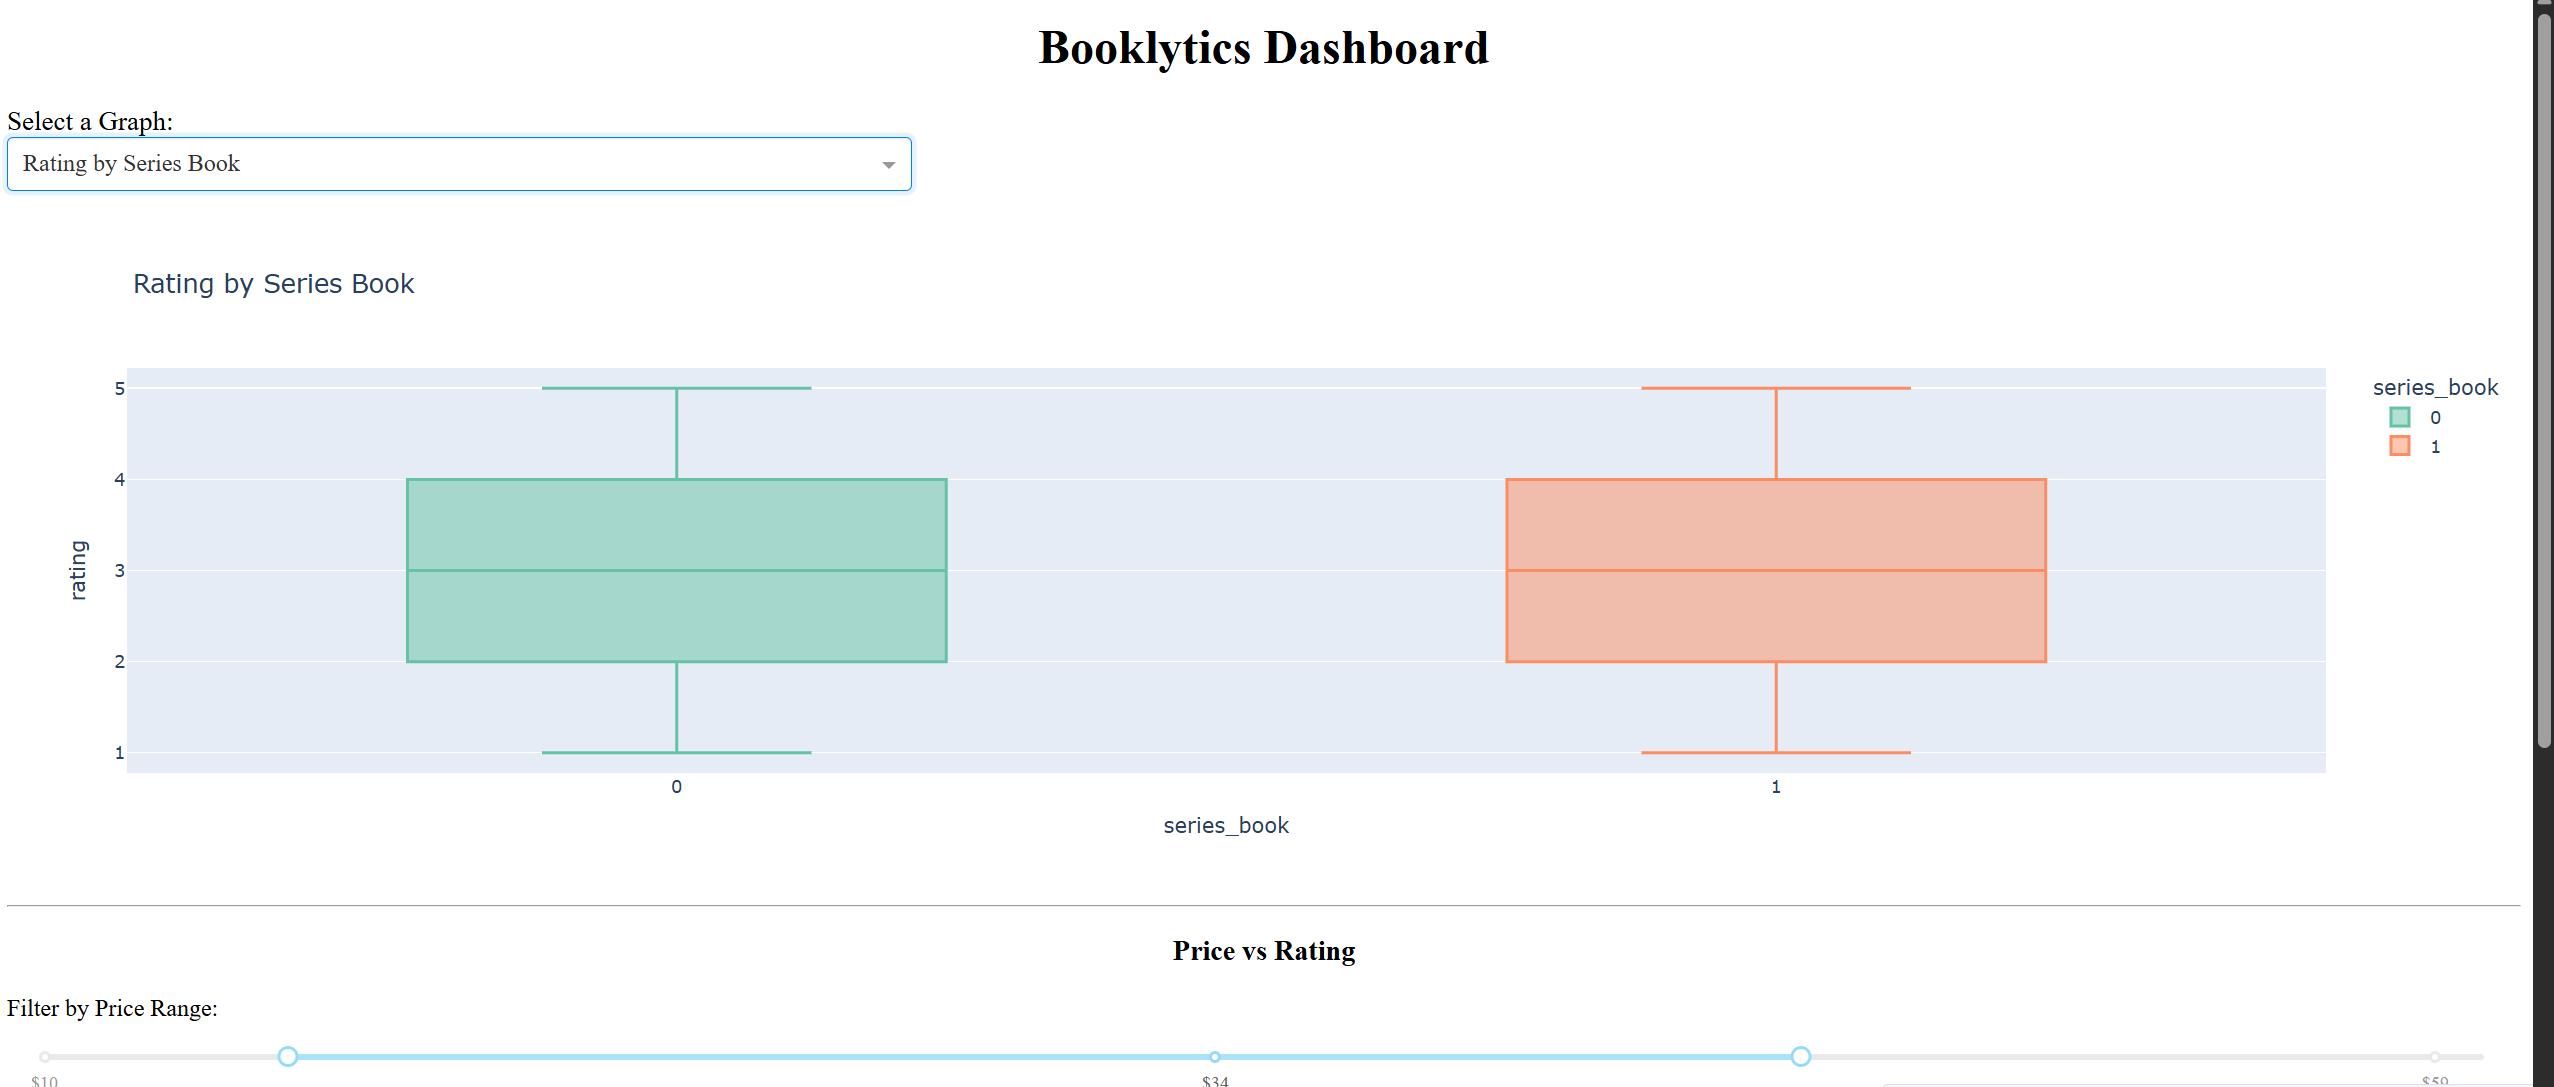

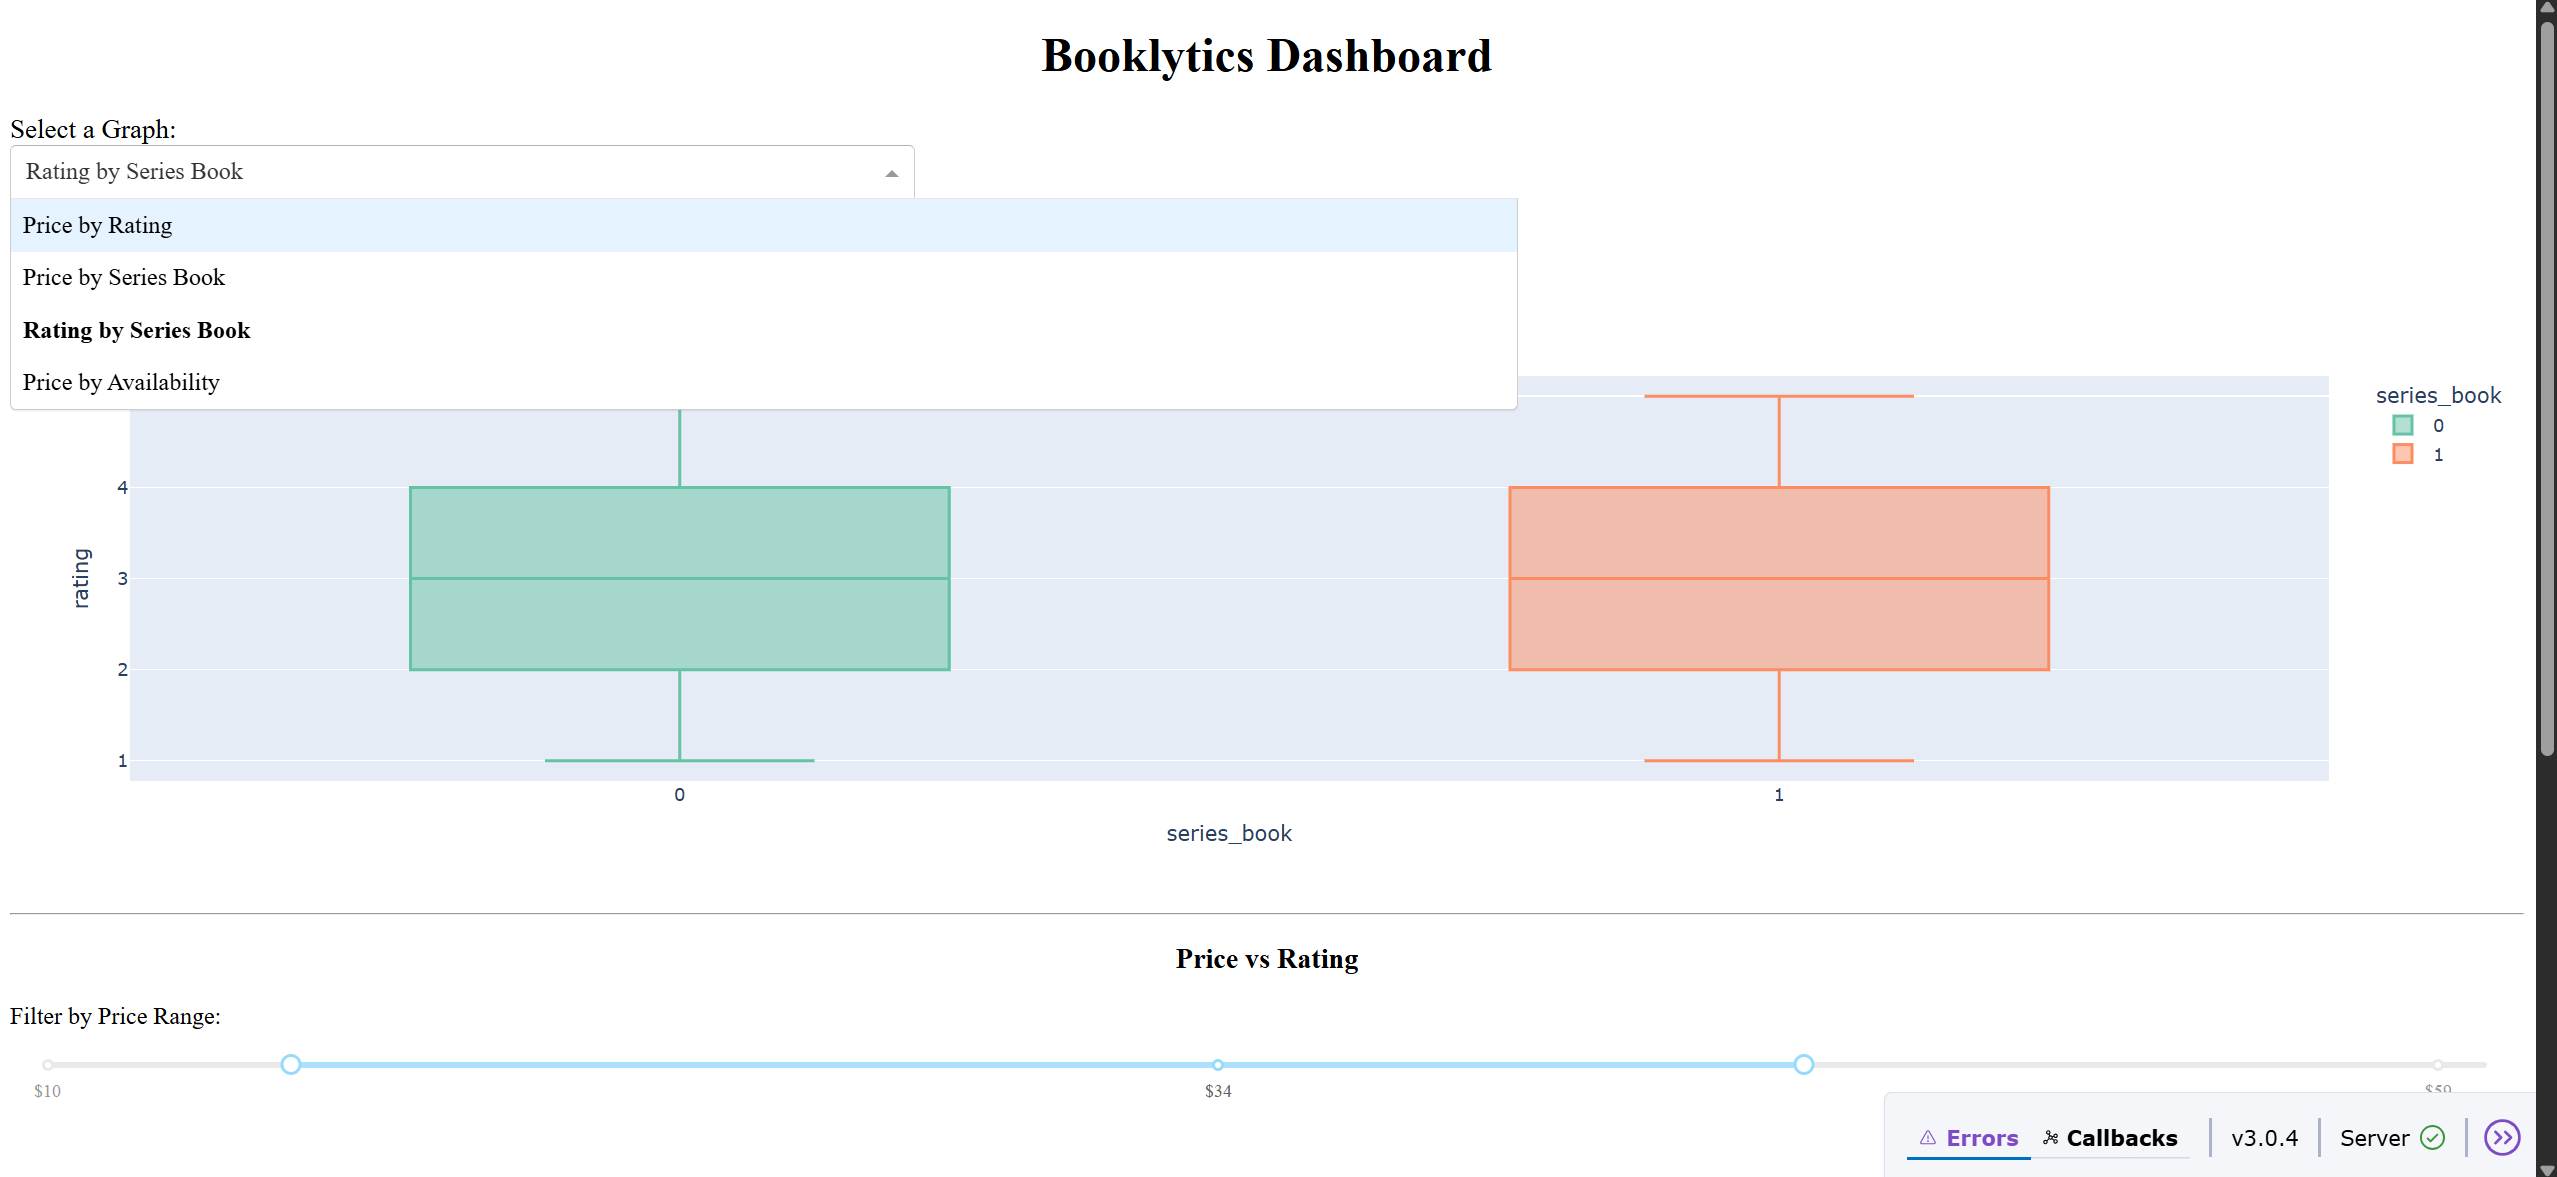

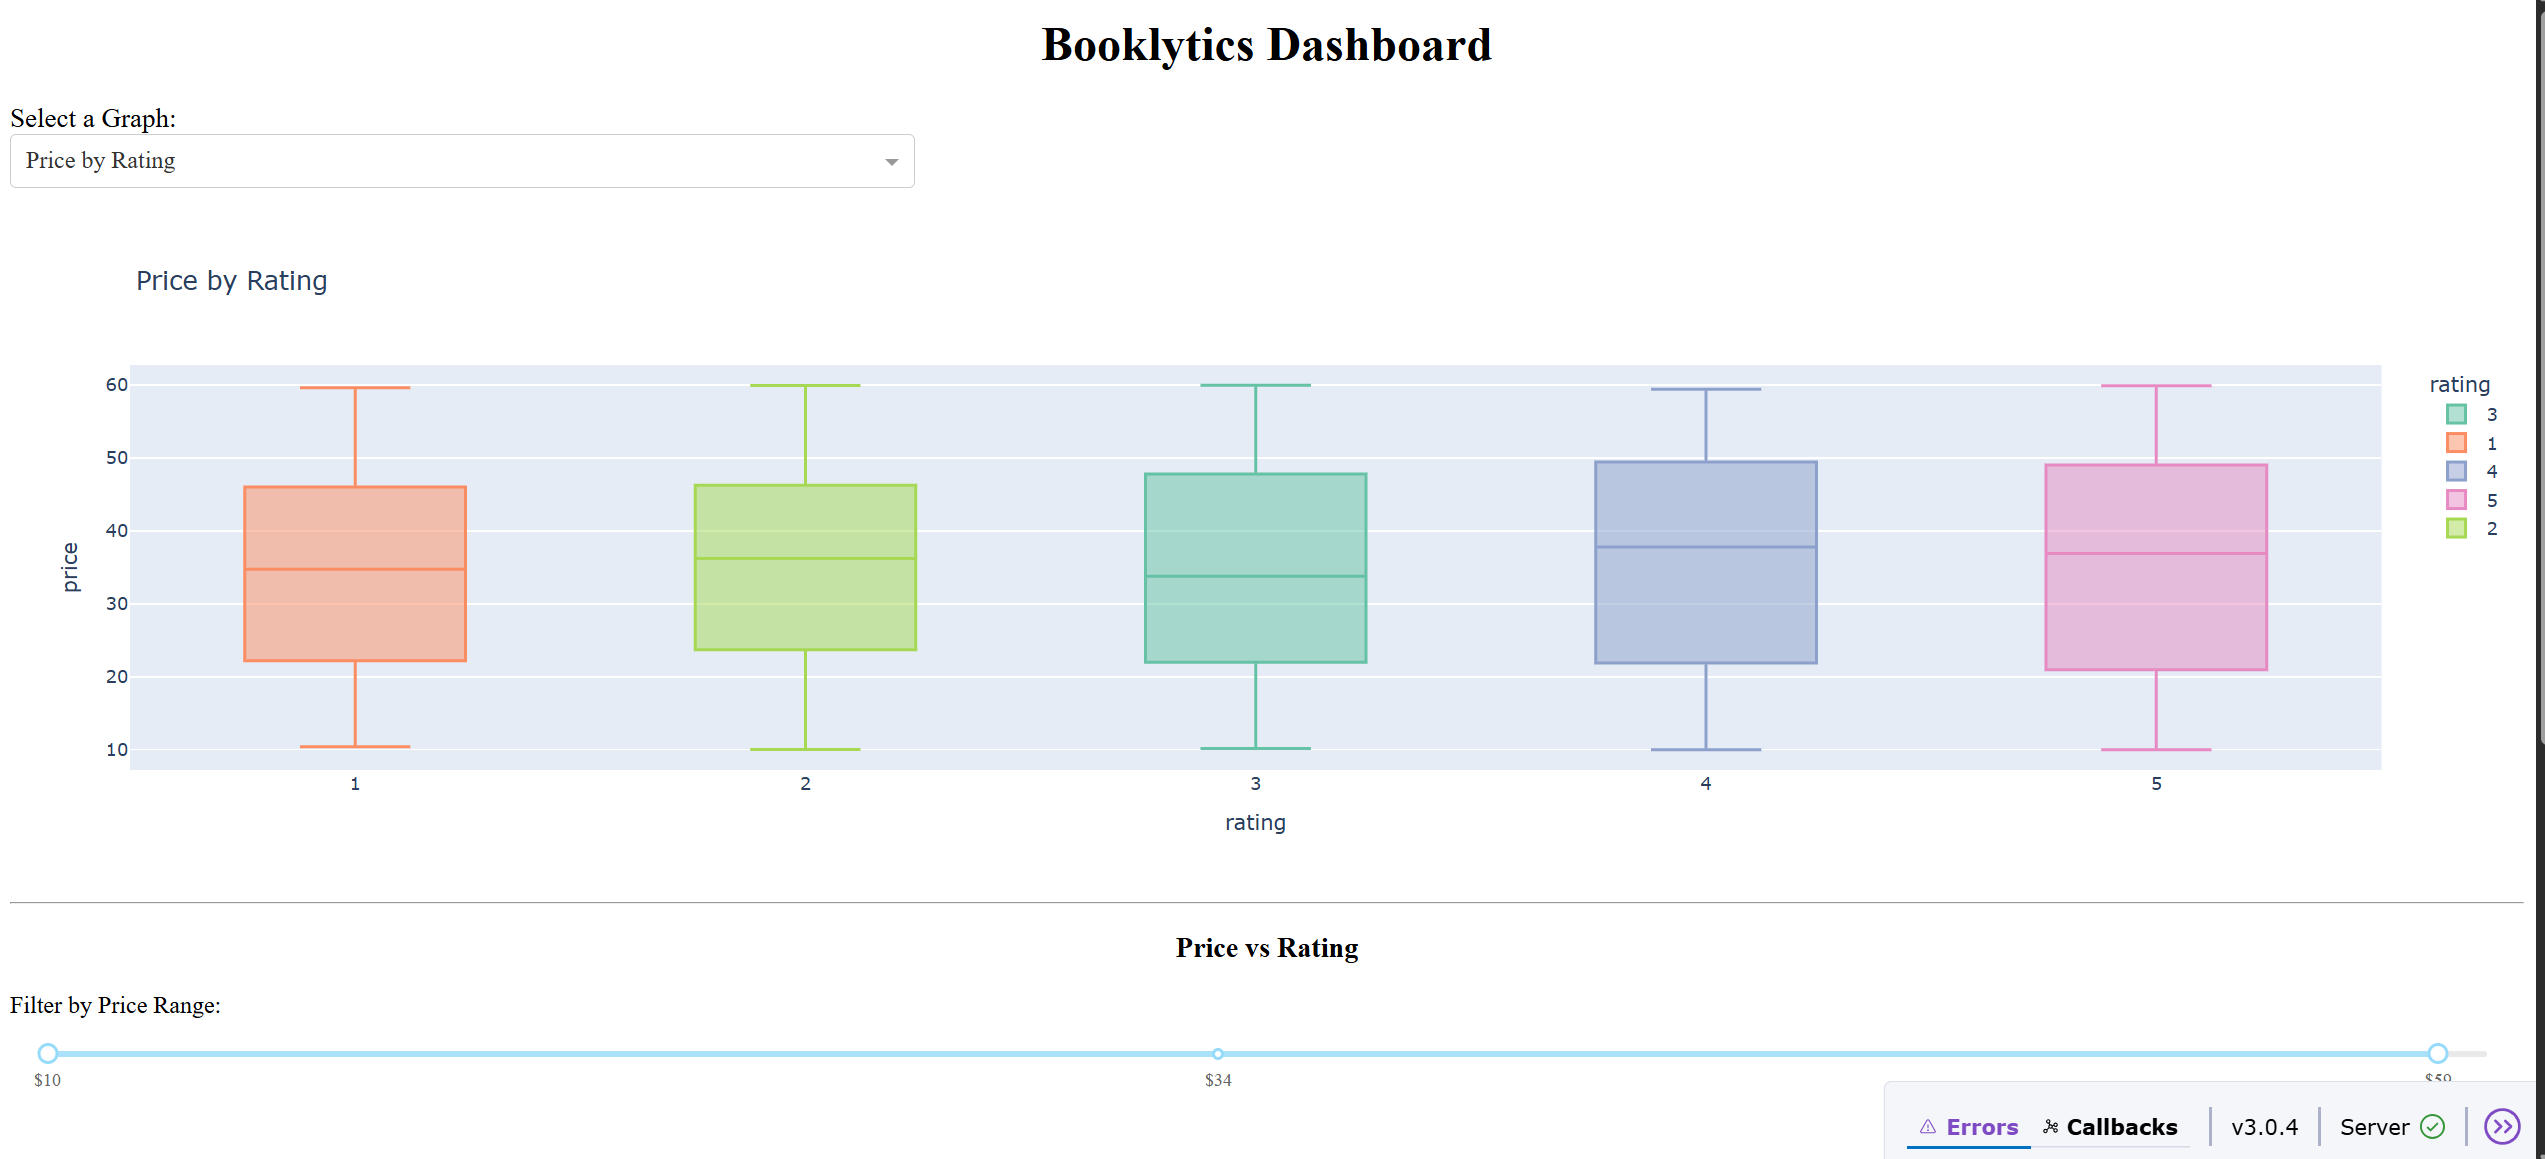

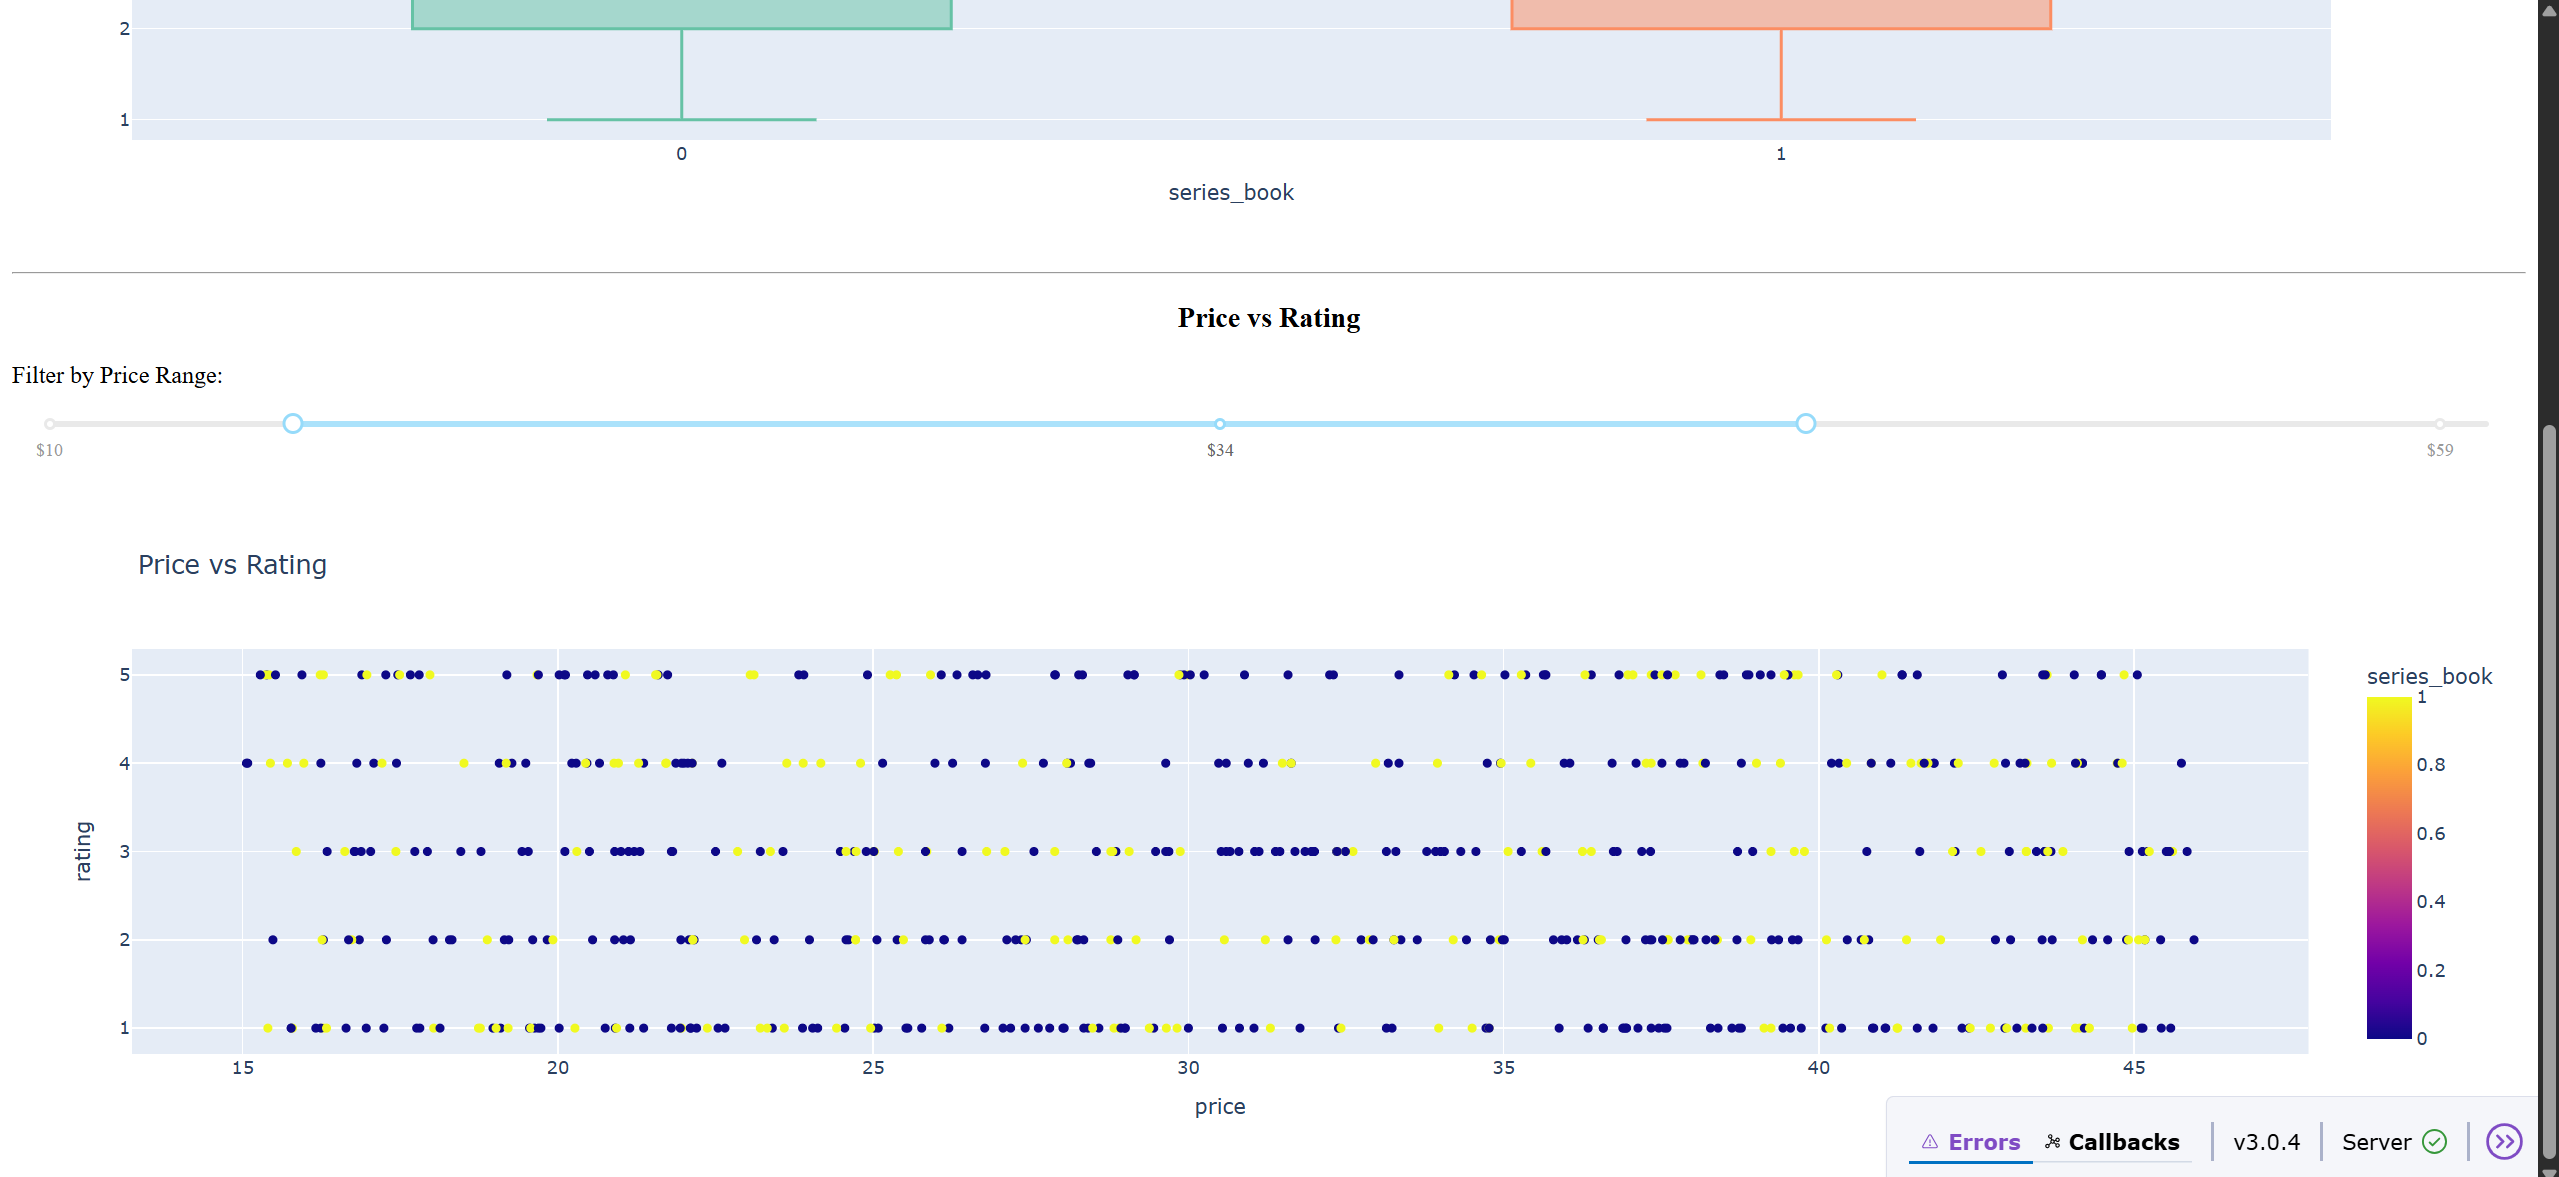

## 7.Key Findings & Insights

Understanding how book pricing might relate to user ratings can provide useful insights for publishers, sellers, or recommendation systems. In this section, we aim to investigate whether books with higher ratings tend to be more expensive—or if there's any meaningful relationship at all.

Using an interactive scatter plot filtered by a price range slider, we visualized this relationship to uncover any potential trends or patterns.


1. No strong correlation was observed between price and rating.
 This suggests that higher-priced books are not necessarily rated higher.

2. Ratings are spread across all price levels, with no obvious outliers.
 Both high-rated and low-rated books appear at various price points.

3. Series books show a wide distribution in both price and rating.
 Being part of a series doesn't guarantee higher price or better rating.


**Important Note**

This dataset is synthetically generated for web scraping practice (from books.toscrape.com) and not from a real-world bookstore.
As such, while the dashboard and visualizations function correctly, the analysis does not reflect actual consumer behavior or market trends. Any patterns found are not valid for business decision-making.

## 8.Conclusion

This project demonstrates the end-to-end process of data scraping, cleaning, exploratory data analysis (EDA), and dashboard development using a synthetically generated dataset of books from books.toscrape.com.
<br><br>

**Key takeaways include:**

- Gained hands-on experience with web scraping using BeautifulSoup and organizing data into a structured CSV.

- Conducted feature engineering (e.g., converting text-based ratings to numerical, binary encoding availability, detecting series books).

- Performed EDA with both matplotlib/seaborn and an interactive dashboard using Plotly Dash, allowing users to explore trends such as price vs rating and availability.

- Built a dynamic interactive dashboard with dropdown selectors and sliders, enabling user-driven exploration of book characteristics.

- Reflected on the limitations of synthetic datasets and the importance of context when interpreting results.

Although the dataset is artificial and not suitable for business insights, the project highlights practical skills relevant to real-world data workflows — including Python scripting, visualization, and building interactive web-based tools.